# Set-Up

In [1]:
# Install Requirements

!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Import packages 

import os
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import torchvision.transforms.functional as TF
import random
import rasterio
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import structural_similarity_index_measure as ssim
import warnings


# Suppress torchmetrics deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torchmetrics")

/Users/tessacannon/Documents/UCL/Dissertation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device to CUDA if available, then MPS, then fall back to CPU

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [5]:
# Set directories

s2_dir = "/Users/tessacannon/Documents/UCL/Dissertation/one_to_one/s2_patches"
lidar_dir = "/Users/tessacannon/Documents/UCL/Dissertation/one_to_one/lidar_patches"

# Data Transformations

In [6]:
# Compute Sentinel-2 mean and standard deviation by channel to normalize the images

def compute_s2_mean_std(s2_dir):
    """
    Computes the per-channel mean and standard deviation for Sentinel-2 image patches in a directory.

    Args:
        s2_dir (str): Path to the directory containing Sentinel-2 .tif files (expected shape: [4, H, W]).

    Returns:
        mean (torch.Tensor): Tensor of shape (4,) containing the mean for each channel.
        std (torch.Tensor): Tensor of shape (4,) containing the standard deviation for each channel.
    """
    s2_paths = sorted(glob.glob(os.path.join(s2_dir, "s2_patch_*.tif")))

    sum_vals = torch.zeros(4)
    sum_sq_vals = torch.zeros(4)
    pixel_count = 0

    # Loop through S2 tif files
    for path in tqdm(s2_paths, desc="Computing S2 stats"):
        with rasterio.open(path) as src:
            arr = torch.from_numpy(src.read().astype(np.float32))  # (4, H, W)
        arr = arr.view(4, -1)
        sum_vals += arr.sum(dim=1)
        sum_sq_vals += (arr ** 2).sum(dim=1)
        pixel_count += arr.shape[1]

    mean = sum_vals / pixel_count
    std = torch.sqrt(sum_sq_vals / pixel_count - mean ** 2)
    return mean, std

mean, std = compute_s2_mean_std(s2_dir) 
print("S2 Mean:", mean)
print("S2 Std:", std)

Computing S2 stats: 100%|██████████| 4437/4437 [00:04<00:00, 894.19it/s]


S2 Mean: tensor([10445.0703, 10330.9932, 10378.2959, 10169.0459])
S2 Std: tensor([160.5491, 147.8918, 131.6966, 157.3023])


In [7]:
# Define dataset class (includes transformations and data augmentation)

class LidarS2Dataset(Dataset):
    def __init__(self, lidar_dir, s2_dir, s2_means, s2_stds, augment=True):
        self.lidar_paths = sorted(glob.glob(os.path.join(lidar_dir, "lidar_patch_*.tif")))
        self.s2_paths = sorted(glob.glob(os.path.join(s2_dir, "s2_patch_*.tif")))
        self.augment = augment
        self.s2_mean = s2_means
        self.s2_std = s2_stds

        # Ensure there are the same number of LiDAR and S2 files
        assert len(self.lidar_paths) == len(self.s2_paths), "Mismatch between LiDAR and S2 patch counts"

    def __len__(self):
        return len(self.lidar_paths)

    def __getitem__(self, idx):
        # Read data file paths at the given index
        lidar = self.read_tif(self.lidar_paths[idx])  # (3, H, W)
        s2 = self.read_tif(self.s2_paths[idx])        # (4, H, W)

        # Normalize Sentinel-2
        s2 = (s2 - self.s2_mean[:, None, None]) / self.s2_std[:, None, None]

        # Data augmentation: horizontal flips, vertical flips, and random rotations with 50% probability 
        if self.augment:
            if random.random() > 0.5:
                lidar = TF.hflip(lidar)
                s2 = TF.hflip(s2)
            if random.random() > 0.5:
                lidar = TF.vflip(lidar)
                s2 = TF.vflip(s2)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                lidar = TF.rotate(lidar, angle)
                s2 = TF.rotate(s2, angle)

        # Return dictionary with the S2, LiDAR, and LiDAR mask separated
        return {
            "s2": s2.float(),              # [4, H, W]
            "lidar": lidar[:2].float(),    # [2, H, W]
            "mask": lidar[2].float()       # [H, W]
        }

    def read_tif(self, path):
        # Read tif file and convert it to float tensor 
        with rasterio.open(path) as src:
            arr = src.read()  # shape: (bands, H, W)
        return torch.from_numpy(arr.astype(np.float32))

# Model Development

In [8]:
# Define model architecture 

# ==== EMBEDDING ====
def timestep_embedding(timesteps, dim):
    """
    Generates sinusoidal timestep embeddings for diffusion modeling.

    Args:
        timesteps (torch.Tensor): 1D tensor of time step indices (shape: [batch_size]).
        dim (int): Dimension of the embedding vector.

    Returns:
        torch.Tensor: Sinusoidal embeddings of shape [batch_size, dim], encoding each timestep as a vector.
    """
    device = timesteps.device
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1, 0, 0))
    return emb

# ==== MODEL BLOCKS ====

# Self Attention Block
class SelfAttention2D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = channels ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.q(x).flatten(2).permute(0, 2, 1)    # B, HW, C
        k = self.k(x).flatten(2)                     # B, C, HW
        v = self.v(x).flatten(2).permute(0, 2, 1)    # B, HW, C

        attn = torch.bmm(q, k) * self.scale          # B, HW, HW
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)                     # B, HW, C
        out = out.permute(0, 2, 1).view(B, C, H, W)
        return self.proj(out + x)

# Convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU(),
        )
        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )
        self.attn = SelfAttention2D(out_channels) if use_attention else None

    def forward(self, x, t):
        h = self.double_conv(x)
        t_emb = self.time_embed(t).view(t.shape[0], -1, 1, 1)
        h = h + t_emb
        if self.attn is not None:
            h = self.attn(h)
        return h

# Down Sampling
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim, use_attention)

    def forward(self, x, t):
        return self.conv(self.pool(x), t)

# Up Sampling
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim, use_attention=False):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim, use_attention)

    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1), t)

# ==== CONDITIONAL UNET ====
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, cond_channels=4, base_channels=128, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_conv = DoubleConv(in_channels + cond_channels, base_channels, embed_dim)
        self.down1 = Down(base_channels, base_channels * 2, embed_dim, use_attention=True)
        self.down2 = Down(base_channels * 2, base_channels * 4, embed_dim, use_attention=True)
        self.down3 = Down(base_channels * 4, base_channels * 8, embed_dim, use_attention=False)

        self.bottleneck_conv = DoubleConv(base_channels * 8, base_channels * 8, embed_dim, use_attention=True)

        self.up3 = Up(base_channels * 8, base_channels * 4, embed_dim, use_attention=False)
        self.up2 = Up(base_channels * 4, base_channels * 2, embed_dim, use_attention=True)
        self.up1 = Up(base_channels * 2, base_channels, embed_dim, use_attention=True)
        self.output_conv = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, cond, t):
        t_emb = timestep_embedding(t, self.embed_dim)
        x = torch.cat([x, cond], dim=1)
        x1 = self.input_conv(x, t_emb)
        x2 = self.down1(x1, t_emb)
        x3 = self.down2(x2, t_emb)
        x4 = self.down3(x3, t_emb)
        x4 = self.bottleneck_conv(x4, t_emb)
        x = self.up3(x4, x3, t_emb)
        x = self.up2(x, x2, t_emb)
        x = self.up1(x, x1, t_emb)
        return self.output_conv(x)

# ==== SCHEDULER ====

# Linear Diffusion Scheduler
class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
    
"""
# Cosine Diffusion Scheduler 

class CosineDiffusionScheduler:
    def __init__(self, timesteps=1000, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        steps = torch.arange(0, timesteps + 1, dtype=torch.float32)
        alphas_cumprod = torch.cos(((steps / timesteps + 0.008) / 1.008) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        self.alpha_cumprod = alphas_cumprod[:-1].to(device)
        self.alphas = self.alpha_cumprod.clone()  # use directly
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
"""

# ==== LOSS FUNCTION ====
def masked_mse_loss(pred, target, mask):
    return ((pred - target) ** 2 * mask.unsqueeze(1)).sum() / mask.sum()


In [9]:
# Training Loop

# === CONFIG ===
config = {
    "epochs": 10,
    "batch_size": 8,
    "lr": 1e-4,
    "timesteps": 1000,
    "device": device
}

# === LOAD DATA ===

dataset = LidarS2Dataset(
    lidar_dir,
    s2_dir,
    s2_means=mean,
    s2_stds=std,
    augment=True
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# === INIT MODEL ===
model = ConditionalUNet(in_channels=2, cond_channels=4).to(config["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])

# === TRAINING LOOP ===
train_losses = []
test_losses = []

for epoch in range(config["epochs"]):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        lidar = batch["lidar"].to(config["device"])
        s2 = batch["s2"].to(config["device"])
        mask = batch["mask"].to(config["device"])

        t = torch.randint(0, config["timesteps"], (lidar.size(0),), device=config["device"]).long()
        noise = torch.randn_like(lidar)
        noisy_lidar = scheduler.q_sample(lidar, t, noise)
        pred_x0 = model(noisy_lidar, s2, t)

        loss = masked_mse_loss(pred_x0, lidar, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === EVALUATION ===
    model.eval()
    running_test_loss = 0.0
    mae_mean_total = 0.0
    rmse_mean_total = 0.0
    mae_std_total = 0.0
    rmse_std_total = 0.0
    n_pixels = 0

    with torch.no_grad():
        for batch in test_loader:
            lidar = batch["lidar"].to(config["device"])
            s2 = batch["s2"].to(config["device"])
            mask = batch["mask"].to(config["device"])

            t = torch.randint(0, config["timesteps"], (lidar.size(0),), device=config["device"]).long()
            noise = torch.randn_like(lidar)
            noisy_lidar = scheduler.q_sample(lidar, t, noise)
            pred_x0 = model(noisy_lidar, s2, t)

            test_loss = masked_mse_loss(pred_x0, lidar, mask)
            running_test_loss += test_loss.item()

            gt_mean = lidar[:, 0:1]
            gt_std = lidar[:, 1:2]
            pred_mean = pred_x0[:, 0:1]
            pred_std = pred_x0[:, 1:2]

            mae_mean_total += F.l1_loss(pred_mean, gt_mean, reduction='sum').item()
            rmse_mean_total += F.mse_loss(pred_mean, gt_mean, reduction='sum').item()
            mae_std_total += F.l1_loss(pred_std, gt_std, reduction='sum').item()
            rmse_std_total += F.mse_loss(pred_std, gt_std, reduction='sum').item()

            n_pixels += lidar.size(0) * lidar.size(2) * lidar.size(3)

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    mae_mean = mae_mean_total / n_pixels
    rmse_mean = (rmse_mean_total / n_pixels) ** 0.5
    mae_std = mae_std_total / n_pixels
    rmse_std = (rmse_std_total / n_pixels) ** 0.5

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Test MAE (Mean): {mae_mean:.4f}, RMSE (Mean): {rmse_mean:.4f}")
    print(f"Test MAE (Std): {mae_std:.4f}, RMSE (Std): {rmse_std:.4f}")

Train Epoch 1: 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


[Epoch 1] Train Loss: 0.0068, Test Loss: 0.0049
Test MAE (Mean): 0.0498, RMSE (Mean): 0.0661
Test MAE (Std): 0.0182, RMSE (Std): 0.0258


Train Epoch 2: 100%|██████████| 500/500 [02:27<00:00,  3.38it/s]


[Epoch 2] Train Loss: 0.0049, Test Loss: 0.0042
Test MAE (Mean): 0.0440, RMSE (Mean): 0.0609
Test MAE (Std): 0.0168, RMSE (Std): 0.0243


Train Epoch 3: 100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


[Epoch 3] Train Loss: 0.0046, Test Loss: 0.0045
Test MAE (Mean): 0.0445, RMSE (Mean): 0.0630
Test MAE (Std): 0.0165, RMSE (Std): 0.0240


Train Epoch 4: 100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


[Epoch 4] Train Loss: 0.0045, Test Loss: 0.0043
Test MAE (Mean): 0.0453, RMSE (Mean): 0.0611
Test MAE (Std): 0.0189, RMSE (Std): 0.0256


Train Epoch 5: 100%|██████████| 500/500 [02:00<00:00,  4.14it/s]


[Epoch 5] Train Loss: 0.0044, Test Loss: 0.0042
Test MAE (Mean): 0.0431, RMSE (Mean): 0.0606
Test MAE (Std): 0.0169, RMSE (Std): 0.0239


Train Epoch 6: 100%|██████████| 500/500 [02:09<00:00,  3.85it/s]


[Epoch 6] Train Loss: 0.0044, Test Loss: 0.0041
Test MAE (Mean): 0.0431, RMSE (Mean): 0.0607
Test MAE (Std): 0.0160, RMSE (Std): 0.0238


Train Epoch 7: 100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


[Epoch 7] Train Loss: 0.0043, Test Loss: 0.0040
Test MAE (Mean): 0.0425, RMSE (Mean): 0.0598
Test MAE (Std): 0.0162, RMSE (Std): 0.0235


Train Epoch 8: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


[Epoch 8] Train Loss: 0.0042, Test Loss: 0.0039
Test MAE (Mean): 0.0423, RMSE (Mean): 0.0590
Test MAE (Std): 0.0161, RMSE (Std): 0.0236


Train Epoch 9: 100%|██████████| 500/500 [02:06<00:00,  3.94it/s]


[Epoch 9] Train Loss: 0.0042, Test Loss: 0.0039
Test MAE (Mean): 0.0421, RMSE (Mean): 0.0593
Test MAE (Std): 0.0160, RMSE (Std): 0.0238


Train Epoch 10: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


[Epoch 10] Train Loss: 0.0042, Test Loss: 0.0038
Test MAE (Mean): 0.0416, RMSE (Mean): 0.0584
Test MAE (Std): 0.0159, RMSE (Std): 0.0234


In [ ]:
# Save Trained Model

model_path = "./trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./trained_model.pth


In [11]:
# Define p_sample methods 

# DDPM

def p_sample_loop_ddpm(model, scheduler, shape, cond, device):
    # Start from pure random noise x_t
    x = torch.randn(shape).to(device)

    # Loop through all of the timesteps in the scheduler from T to 1
    for t in reversed(range(scheduler.timesteps)):

        # Create a batch-sized tensor with each element set to the timestep t
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        # Predict the clean input x_0 given the pure random noise and the timestep t 
        pred_x0 = model(x, cond, t_batch)

        # Get the alphas and betas for each timestep from the diffusion scheduler
        alpha_t = scheduler.alphas[t]
        alpha_cumprod_t = scheduler.alpha_cumprod[t]
        alpha_cumprod_prev_t = scheduler.alpha_cumprod_prev[t]
        beta_t = 1 - alpha_t

        # If we're not at the final time_step, add noise 
        if t > 0:
            noise = torch.randn_like(x)
        # At t=0, we stop adding noise and just return the predicted sample
        else:
            noise = torch.zeros_like(x)

        # Get coefficient for x_0
        coef1 = torch.sqrt(alpha_cumprod_prev_t) * beta_t / (1 - alpha_cumprod_t)
        
        # Get coefficient for x_t
        coef2 = torch.sqrt(alpha_t) * (1 - alpha_cumprod_prev_t) / (1 - alpha_cumprod_t)

        # Calculate posterior mean of x_t-1 given x_t
        mean = coef1 * pred_x0 + coef2 * x

        # Calculate the variance of x_t-1 given x_t
        var = beta_t * (1 - alpha_cumprod_prev_t) / (1 - alpha_cumprod_t)
        std = torch.sqrt(var)

        # Produce x_t-1 by sampling from the Gaussian 
        x = mean + std * noise

    # Return the final predicted sample
    return x

# DDIM

def p_sample_loop_ddim(model, scheduler, shape, cond, device, eta=0.0):
    # Start from pure random noise x_t
    x = torch.randn(shape).to(device)

    # Loop through all of the timesteps in the scheduler from T to 1
    for i, t in enumerate(reversed(range(scheduler.timesteps))):

        # Create a batch-sized tensor with each element set to the timestep t
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        # Predict the clean input x_0 given the current sample and the timestep t 
        pred_x0 = model(x, cond, t_batch)

        # Get the alphas for each timestep from the diffusion scheduler
        alpha_cumprod_t = scheduler.alpha_cumprod[t]
        
        # Get the previous timestep (or 0 if this is the last step)
        if i < scheduler.timesteps - 1:
            t_prev = list(reversed(range(scheduler.timesteps)))[i + 1]
            alpha_cumprod_prev_t = scheduler.alpha_cumprod[t_prev]
        else:
            alpha_cumprod_prev_t = torch.tensor(1.0)

        # Calculate the predicted noise (epsilon)
        pred_epsilon = (x - torch.sqrt(alpha_cumprod_t) * pred_x0) / torch.sqrt(1 - alpha_cumprod_t)

        # Calculate the direction pointing towards x_t
        dir_xt = torch.sqrt(1 - alpha_cumprod_prev_t - eta**2 * (1 - alpha_cumprod_t / alpha_cumprod_prev_t)) * pred_epsilon

        # If we're not at the final timestep and eta > 0, add stochastic noise
        if i < scheduler.timesteps - 1 and eta > 0:
            noise = torch.randn_like(x)
            sigma_t = eta * torch.sqrt((1 - alpha_cumprod_prev_t) / (1 - alpha_cumprod_t)) * torch.sqrt(1 - alpha_cumprod_t / alpha_cumprod_prev_t)
        else:
            noise = torch.zeros_like(x)
            sigma_t = 0

        # Calculate the deterministic part: x_0 prediction scaled by alpha
        x0_part = torch.sqrt(alpha_cumprod_prev_t) * pred_x0

        # Produce x_t-1 using DDIM formula
        x = x0_part + dir_xt + sigma_t * noise

    # Return the final denoised sample
    return x


# PLMS

def p_sample_loop_plms(model, scheduler, shape, cond, device, order=4):
    # Start from pure random noise x_t
    x = torch.randn(shape).to(device)
    
    # Store previous noise predictions for PLMS
    prev_eps = []

    # Loop through all of the timesteps in the scheduler from T to 1
    for i, t in enumerate(reversed(range(scheduler.timesteps))):

        # Create a batch-sized tensor with each element set to the timestep t
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        # Predict the clean input x_0 given the current sample and the timestep t 
        pred_x0 = model(x, cond, t_batch)

        # Get the alphas for each timestep from the diffusion scheduler
        alpha_cumprod_t = scheduler.alpha_cumprod[t]
        
        # Get the previous timestep (or 0 if this is the last step)
        if i < scheduler.timesteps - 1:
            t_prev = list(reversed(range(scheduler.timesteps)))[i + 1]
            alpha_cumprod_prev_t = scheduler.alpha_cumprod[t_prev]
        else:
            alpha_cumprod_prev_t = torch.tensor(1.0)

        # Calculate the predicted noise (epsilon)
        pred_epsilon = (x - torch.sqrt(alpha_cumprod_t) * pred_x0) / torch.sqrt(1 - alpha_cumprod_t)
        
        # Add current epsilon to the history
        prev_eps.append(pred_epsilon)
        
        # Keep only the required number of previous predictions
        if len(prev_eps) > order:
            prev_eps = prev_eps[-order:]

        # Calculate PLMS coefficients based on the number of stored predictions
        if len(prev_eps) == 1:
            # First step: use Euler method
            eps = prev_eps[-1]
        elif len(prev_eps) == 2:
            # Second step: use 2nd order Adams-Bashforth
            eps = (3/2) * prev_eps[-1] - (1/2) * prev_eps[-2]
        elif len(prev_eps) == 3:
            # Third step: use 3rd order Adams-Bashforth
            eps = (23/12) * prev_eps[-1] - (16/12) * prev_eps[-2] + (5/12) * prev_eps[-3]
        else:
            # Fourth step and beyond: use 4th order Adams-Bashforth
            eps = (55/24) * prev_eps[-1] - (59/24) * prev_eps[-2] + (37/24) * prev_eps[-3] - (9/24) * prev_eps[-4]

        # Calculate the deterministic part: x_0 prediction scaled by alpha
        x0_part = torch.sqrt(alpha_cumprod_prev_t) * pred_x0

        # Calculate the direction pointing towards x_t using PLMS-corrected epsilon
        dir_xt = torch.sqrt(1 - alpha_cumprod_prev_t) * eps

        # At t=0, we stop adding noise and just return the predicted sample
        if i == scheduler.timesteps - 1:
            noise = torch.zeros_like(x)
        else:
            noise = torch.zeros_like(x)  # PLMS is typically deterministic

        # Produce x_t-1 using PLMS formula
        x = x0_part + dir_xt + noise

    # Return the final denoised sample
    return x

# Model Evaluation

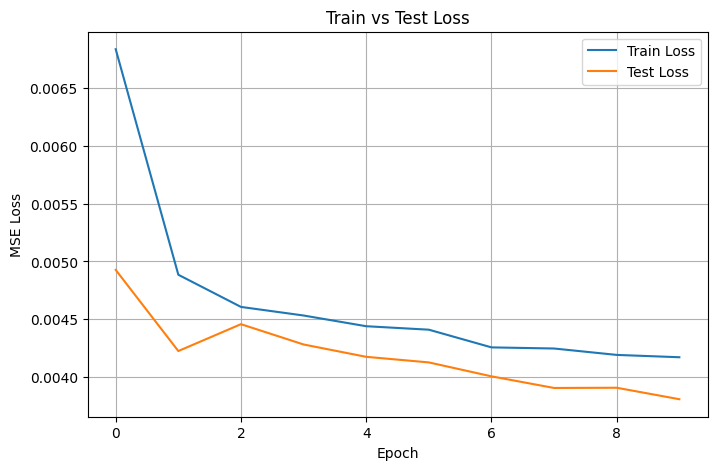

In [12]:
# Plot training/validation loss curve

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
#plt.savefig("loss_plot.png")
plt.show()

In [13]:
# Helper functions for visualization and evaluation

def rescale_batch_channelwise(x):
    """
    Rescales each channel of each image in a batch independently to the [0, 1] range. This ensures that each channel of every image 
    spans the full intensity range, regardless of its original minimum and maximum values.

    Args:
        x (torch.Tensor): Input tensor of shape (B, C, H, W), where B is batch size, C is channels.

    Returns:
        torch.Tensor: Rescaled tensor of the same shape, with each (B, C) channel normalized to [0, 1].
    """
    # x is (B, C, H, W)
    B, C, H, W = x.shape
    x_reshaped = x.view(B, C, -1)
    vmin = x_reshaped.min(dim=2, keepdim=True).values
    vmax = x_reshaped.max(dim=2, keepdim=True).values
    x_scaled = (x_reshaped - vmin) / (vmax - vmin + 1e-8)
    return x_scaled.view(B, C, H, W)

def compute_nrmse(gt, pred):
    """
    Computes the Normalized Root Mean Squared Error (NRMSE) between predicted and ground truth tensors.

    Args:
        gt (np.ndarray or torch.Tensor): Ground truth tensor or array, already moved to CPU.
        pred (np.ndarray or torch.Tensor): Predicted tensor or array, same shape as `gt`.

    Returns:
        float: Normalized RMSE, expressed as a percentage of the range of the ground truth.
    """
    rmse = ((gt.flatten() - pred.flatten()) ** 2).mean() ** 0.5
    value_range = gt.max() - gt.min()
    return (rmse / value_range) * 100

def normalize(t):
    """
    Normalizes a single tensor to the [0, 1] range.

    Args:
        t (torch.Tensor): Input tensor to be normalized.

    Returns:
        torch.Tensor: Normalized tensor with values in [0, 1].
    """
    return (t - t.min()) / (t.max() - t.min() + 1e-8)


### Batch Sample #1


Sampling method: DDPM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0482      |     0.0181     
RMSE                 |     0.0683      |     0.0288     
Normalized RMSE (%)  |      6.63       |      4.12      
SSIM                 |     0.4812      |     0.4738     


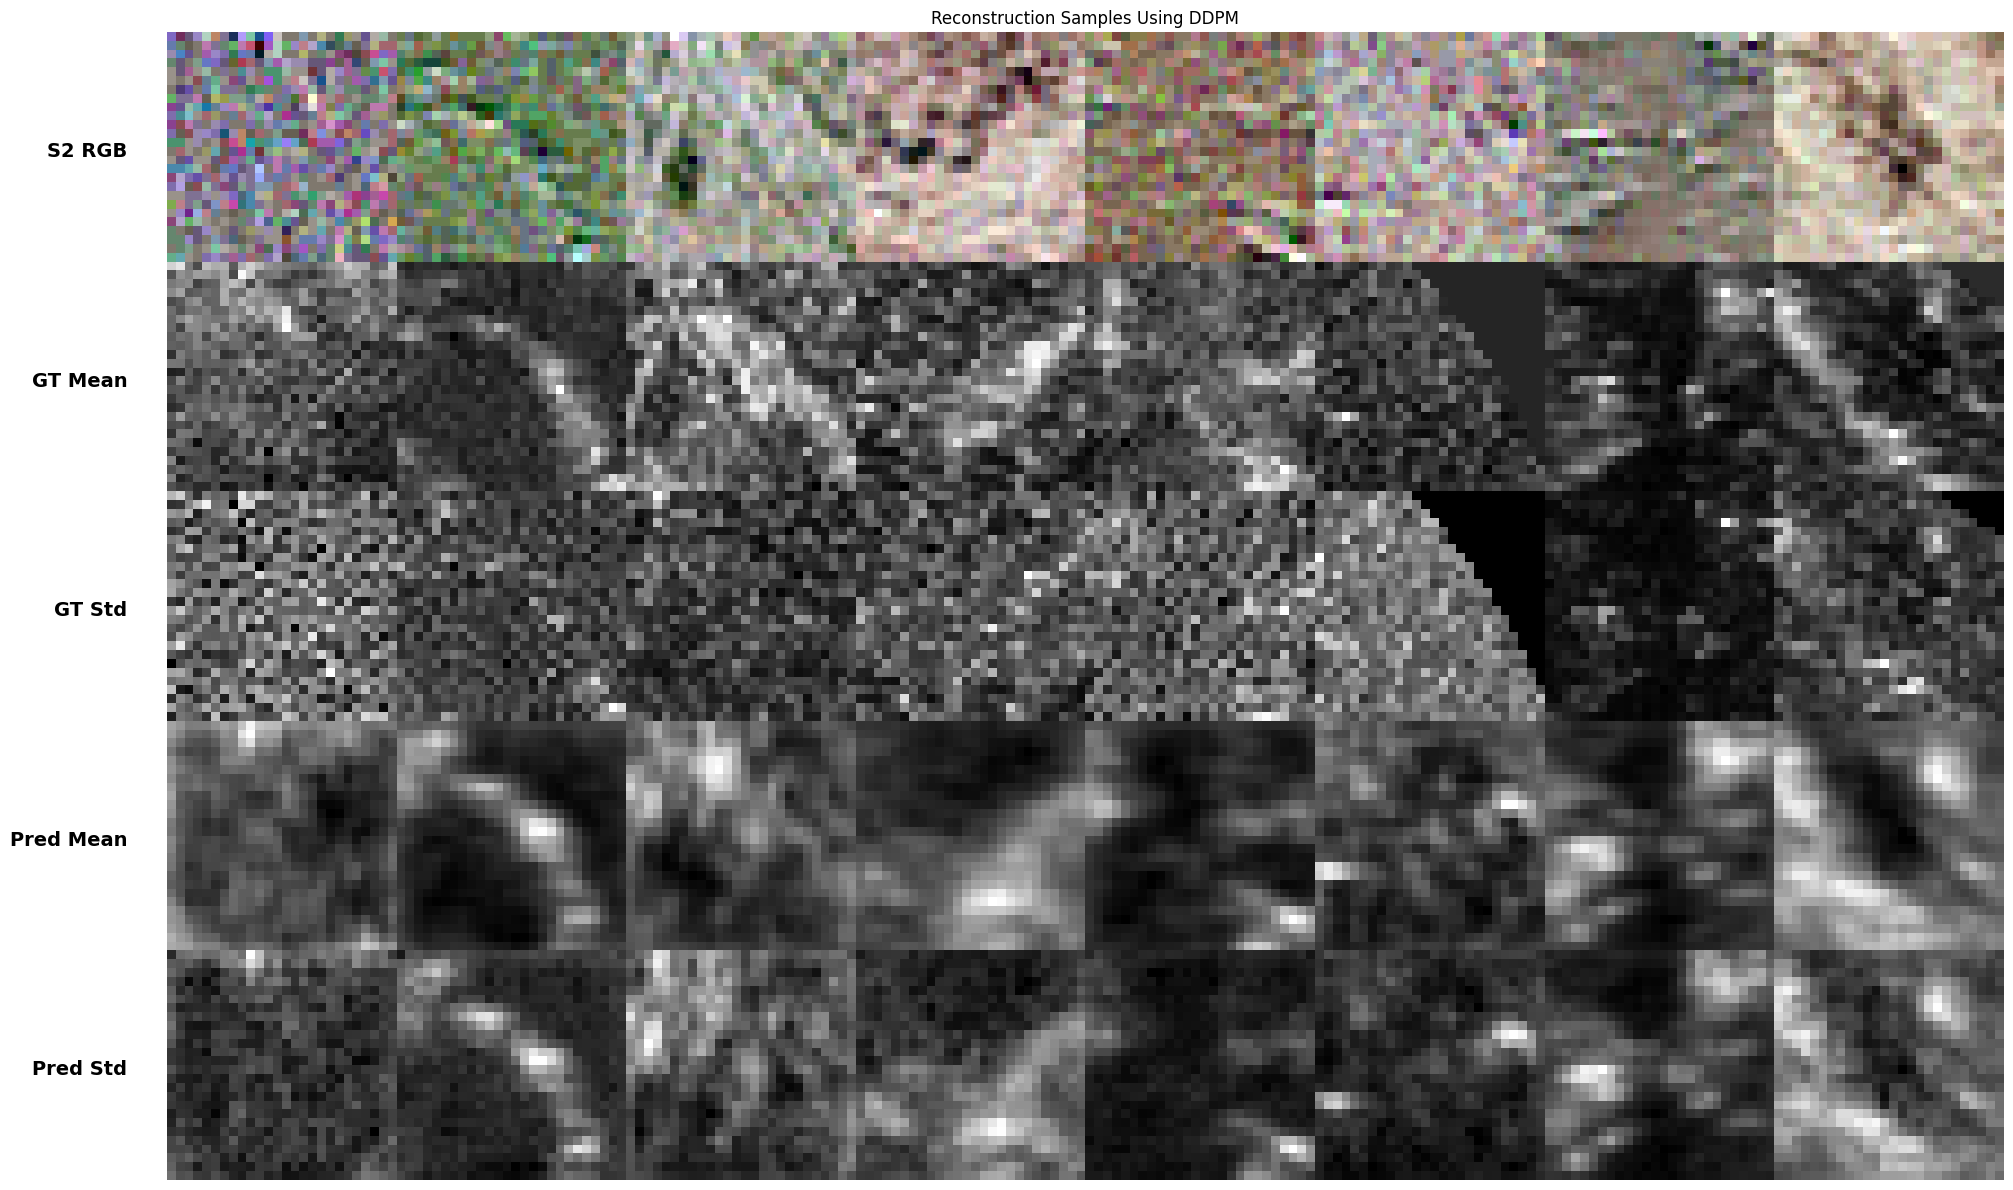


Sampling method: DDIM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0484      |     0.0181     
RMSE                 |     0.0686      |     0.0288     
Normalized RMSE (%)  |      6.66       |      4.12      
SSIM                 |     0.4773      |     0.4728     


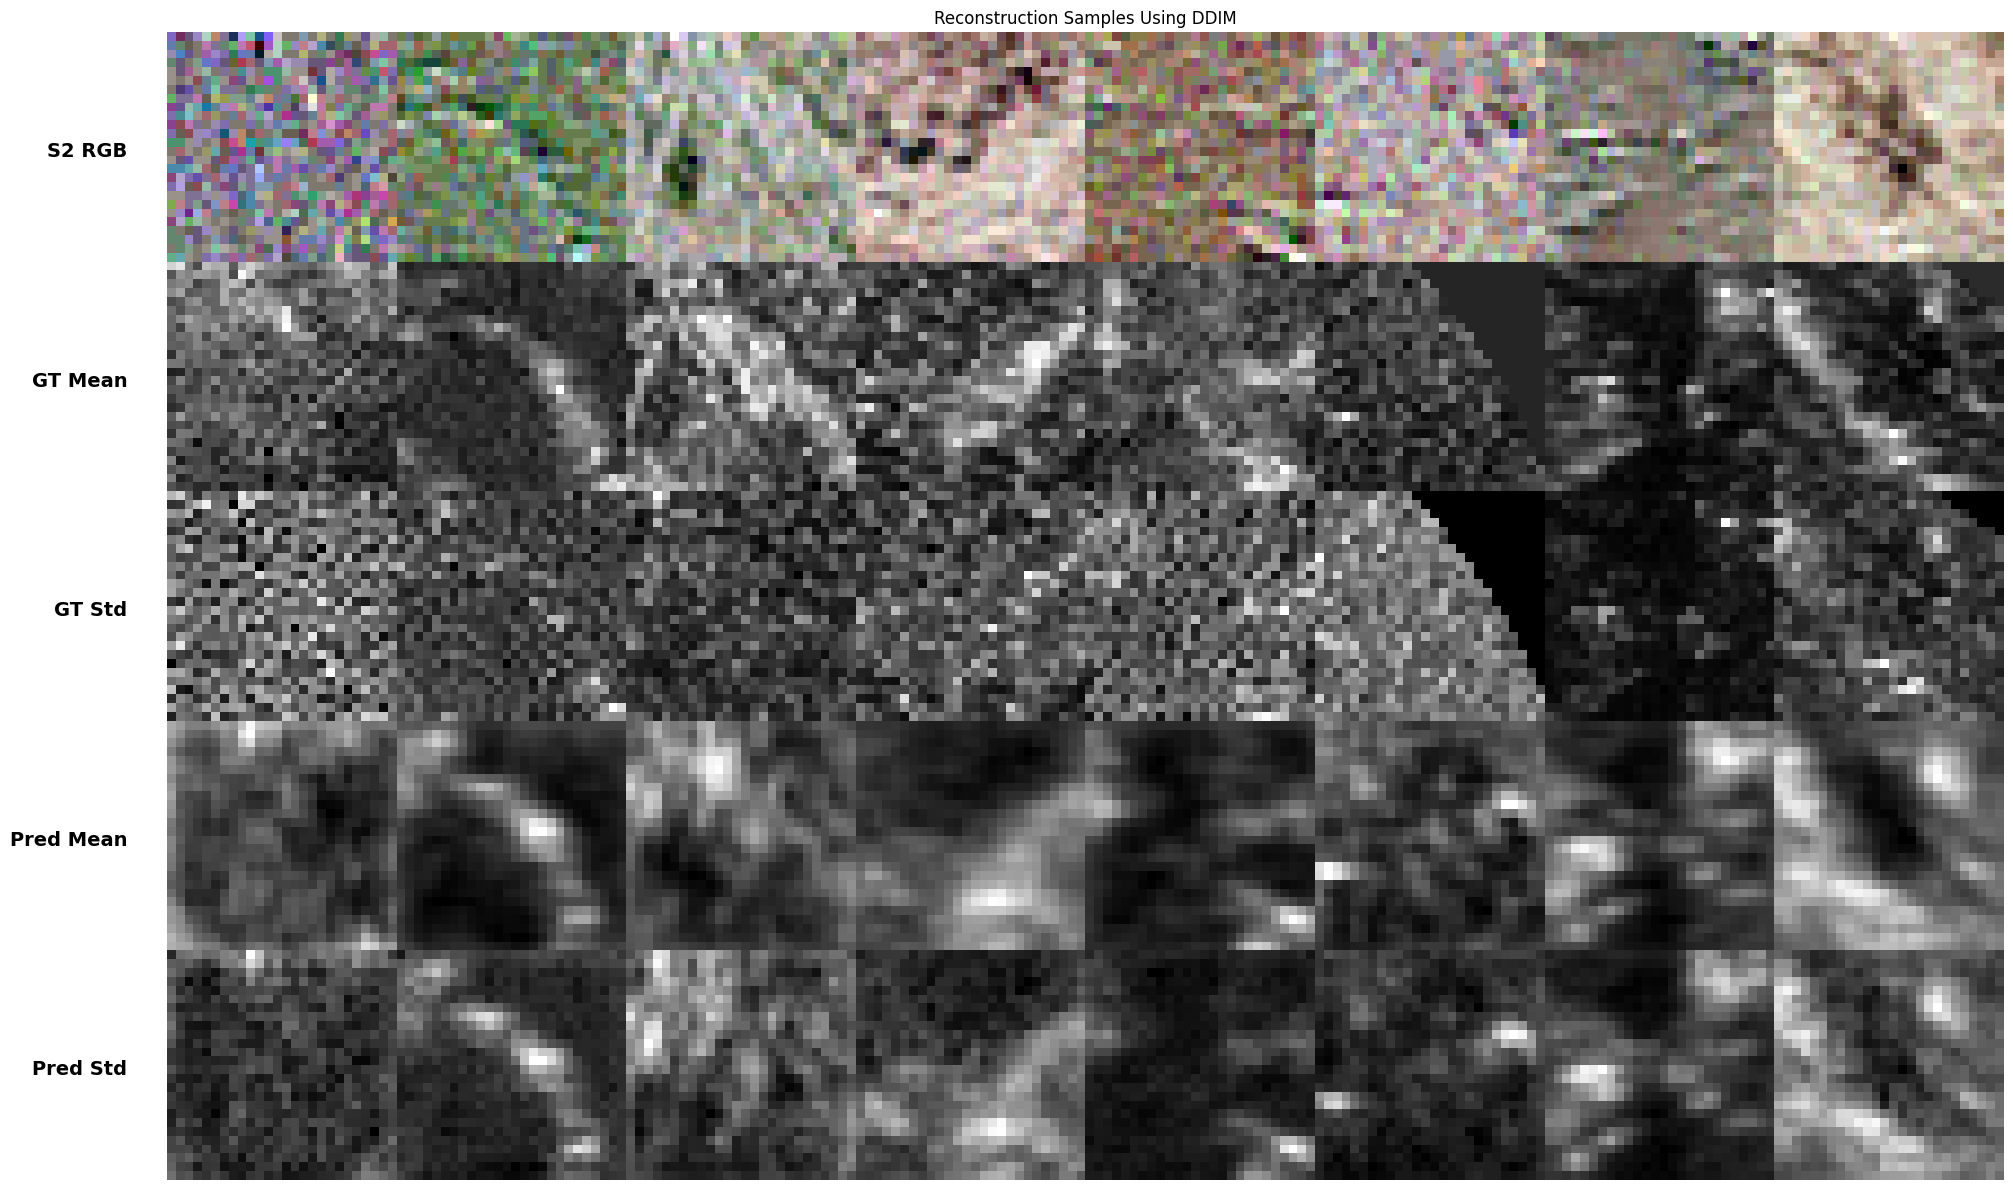


Sampling method: PLMS
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0486      |     0.0181     
RMSE                 |     0.0689      |     0.0289     
Normalized RMSE (%)  |      6.69       |      4.12      
SSIM                 |     0.4764      |     0.4726     


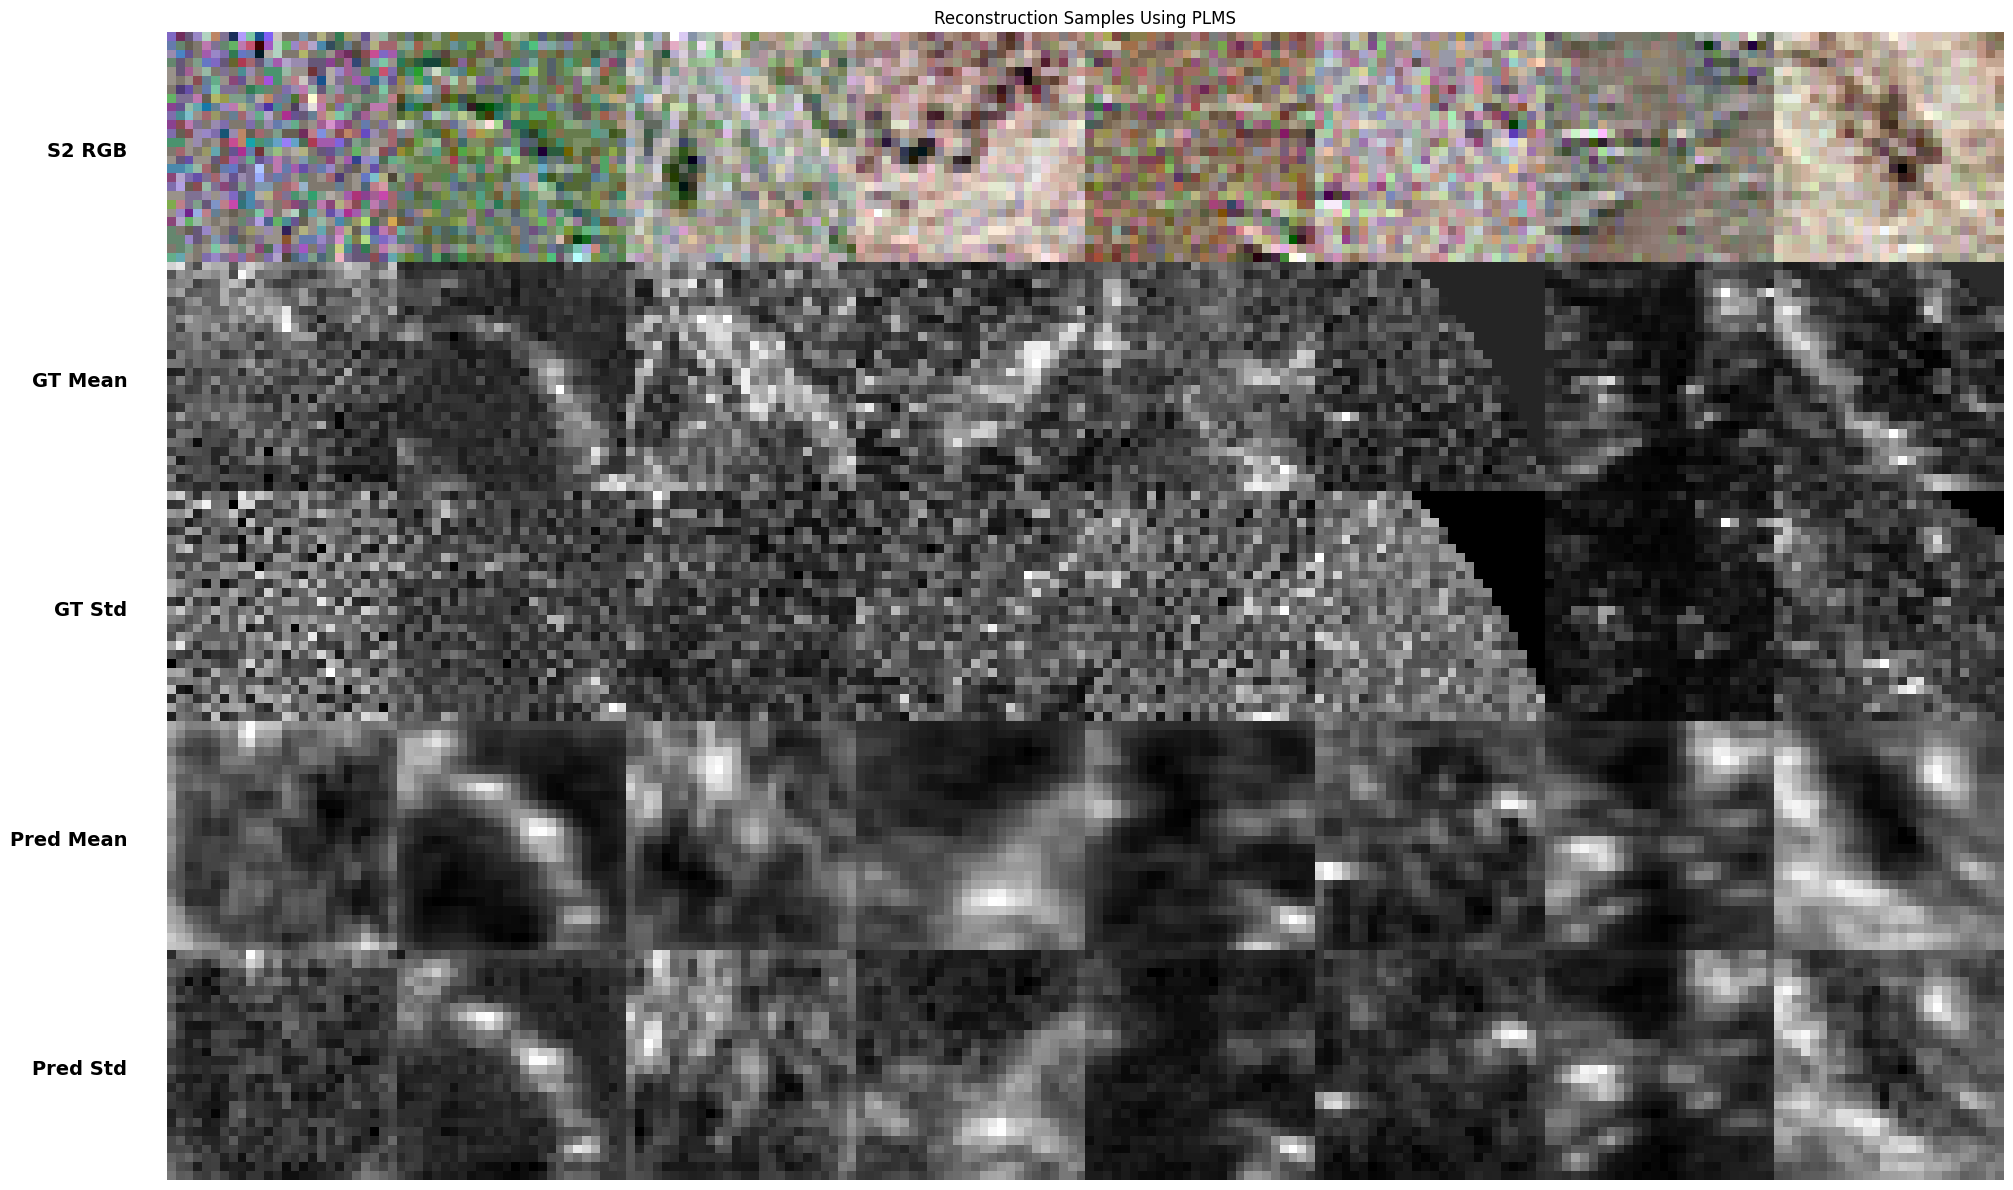

In [14]:
# Reconstruction Evaluation

# Set model to eval
model.eval()

# Extract sample batch from the test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
batch = next(iter(test_loader))
s2 = batch["s2"].to(config["device"])
lidar = batch["lidar"].to(config["device"])

# Define p sampling methods to test
p_samplers = {"DDPM": p_sample_loop_ddpm, "DDIM": p_sample_loop_ddim, "PLMS": p_sample_loop_plms}

# Perform evaluation for each p sampling method
for p_sampler in p_samplers: 
    print(f"\nSampling method: {p_sampler}")
    
    with torch.no_grad():
        generated = p_samplers[p_sampler](model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])
        
        # Get GT and pred channels
        gt_mean = lidar[:, 0:1].cpu()
        gt_std = lidar[:, 1:2].cpu()
        pred_mean = generated[:, 0:1].cpu()
        pred_std = generated[:, 1:2].cpu()

        # Normalize to [0, 1] for SSIM/LPIPS
        
        gt_mean_norm = normalize(gt_mean)
        gt_std_norm = normalize(gt_std)
        pred_mean_norm = normalize(pred_mean)
        pred_std_norm = normalize(pred_std)

        # RMSE, MAE
        mae_mean = F.l1_loss(pred_mean, gt_mean).item()
        rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
        mae_std = F.l1_loss(pred_std, gt_std).item()
        rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

        # Normalized RMSE
        nrmse_mean = compute_nrmse(gt_mean.numpy(), pred_mean.numpy())
        nrmse_std = compute_nrmse(gt_std.numpy(), pred_std.numpy())

        # SSIM
        ssim_mean = ssim(pred_mean_norm, gt_mean_norm, data_range=1.0).item()
        ssim_std = ssim(pred_std_norm, gt_std_norm, data_range=1.0).item()

        # Print results
        print(f"{'Metric':<20} | {'Mean Elevation':^15} | {'Std Elevation':^15}")
        print("-" * 55)
        print(f"{'MAE':<20} | {mae_mean:^15.4f} | {mae_std:^15.4f}")
        print(f"{'RMSE':<20} | {rmse_mean:^15.4f} | {rmse_std:^15.4f}")
        print(f"{'Normalized RMSE (%)':<20} | {nrmse_mean:^15.2f} | {nrmse_std:^15.2f}")
        print(f"{'SSIM':<20} | {ssim_mean:^15.4f} | {ssim_std:^15.4f}")

        # Reconstruction Visualization
        s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())
        gt_mean_vis = rescale_batch_channelwise(gt_mean[:8])
        gt_std_vis = rescale_batch_channelwise(gt_std[:8])
        pred_mean_vis = rescale_batch_channelwise(pred_mean[:8])
        pred_std_vis = rescale_batch_channelwise(pred_std[:8])

        vis_list = []
        for i in range(8):
            stacked = torch.cat([
                s2_vis[i],
                gt_mean_vis[i].repeat(3, 1, 1),
                gt_std_vis[i].repeat(3, 1, 1),
                pred_mean_vis[i].repeat(3, 1, 1),
                pred_std_vis[i].repeat(3, 1, 1)
            ], dim=1)
            vis_list.append(stacked)

        final_grid = torch.cat(vis_list, dim=2)
        img = final_grid.permute(1, 2, 0).numpy()

        # Add row titles
        row_labels = ["S2 RGB", "GT Mean", "GT Std", "Pred Mean", "Pred Std"]
        n_rows = len(row_labels)
        row_height = img.shape[0] // n_rows

        plt.figure(figsize=(40, 12))
        plt.imshow(img)
        plt.title(f"Reconstruction Samples Using {p_sampler}")
        plt.axis("off")

        # Add row labels on the left
        for idx, label in enumerate(row_labels):
            y = row_height * idx + row_height // 2
            plt.text(-5, y, label, va='center', ha='right', fontsize=14, fontweight='bold', color='black', backgroundcolor='white')

        plt.tight_layout()
        plt.show()


### Batch Sample #2


Sampling method: DDPM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0368      |     0.0167     
RMSE                 |     0.0492      |     0.0237     
Normalized RMSE (%)  |      6.95       |      6.51      
SSIM                 |     0.3380      |     0.3097     


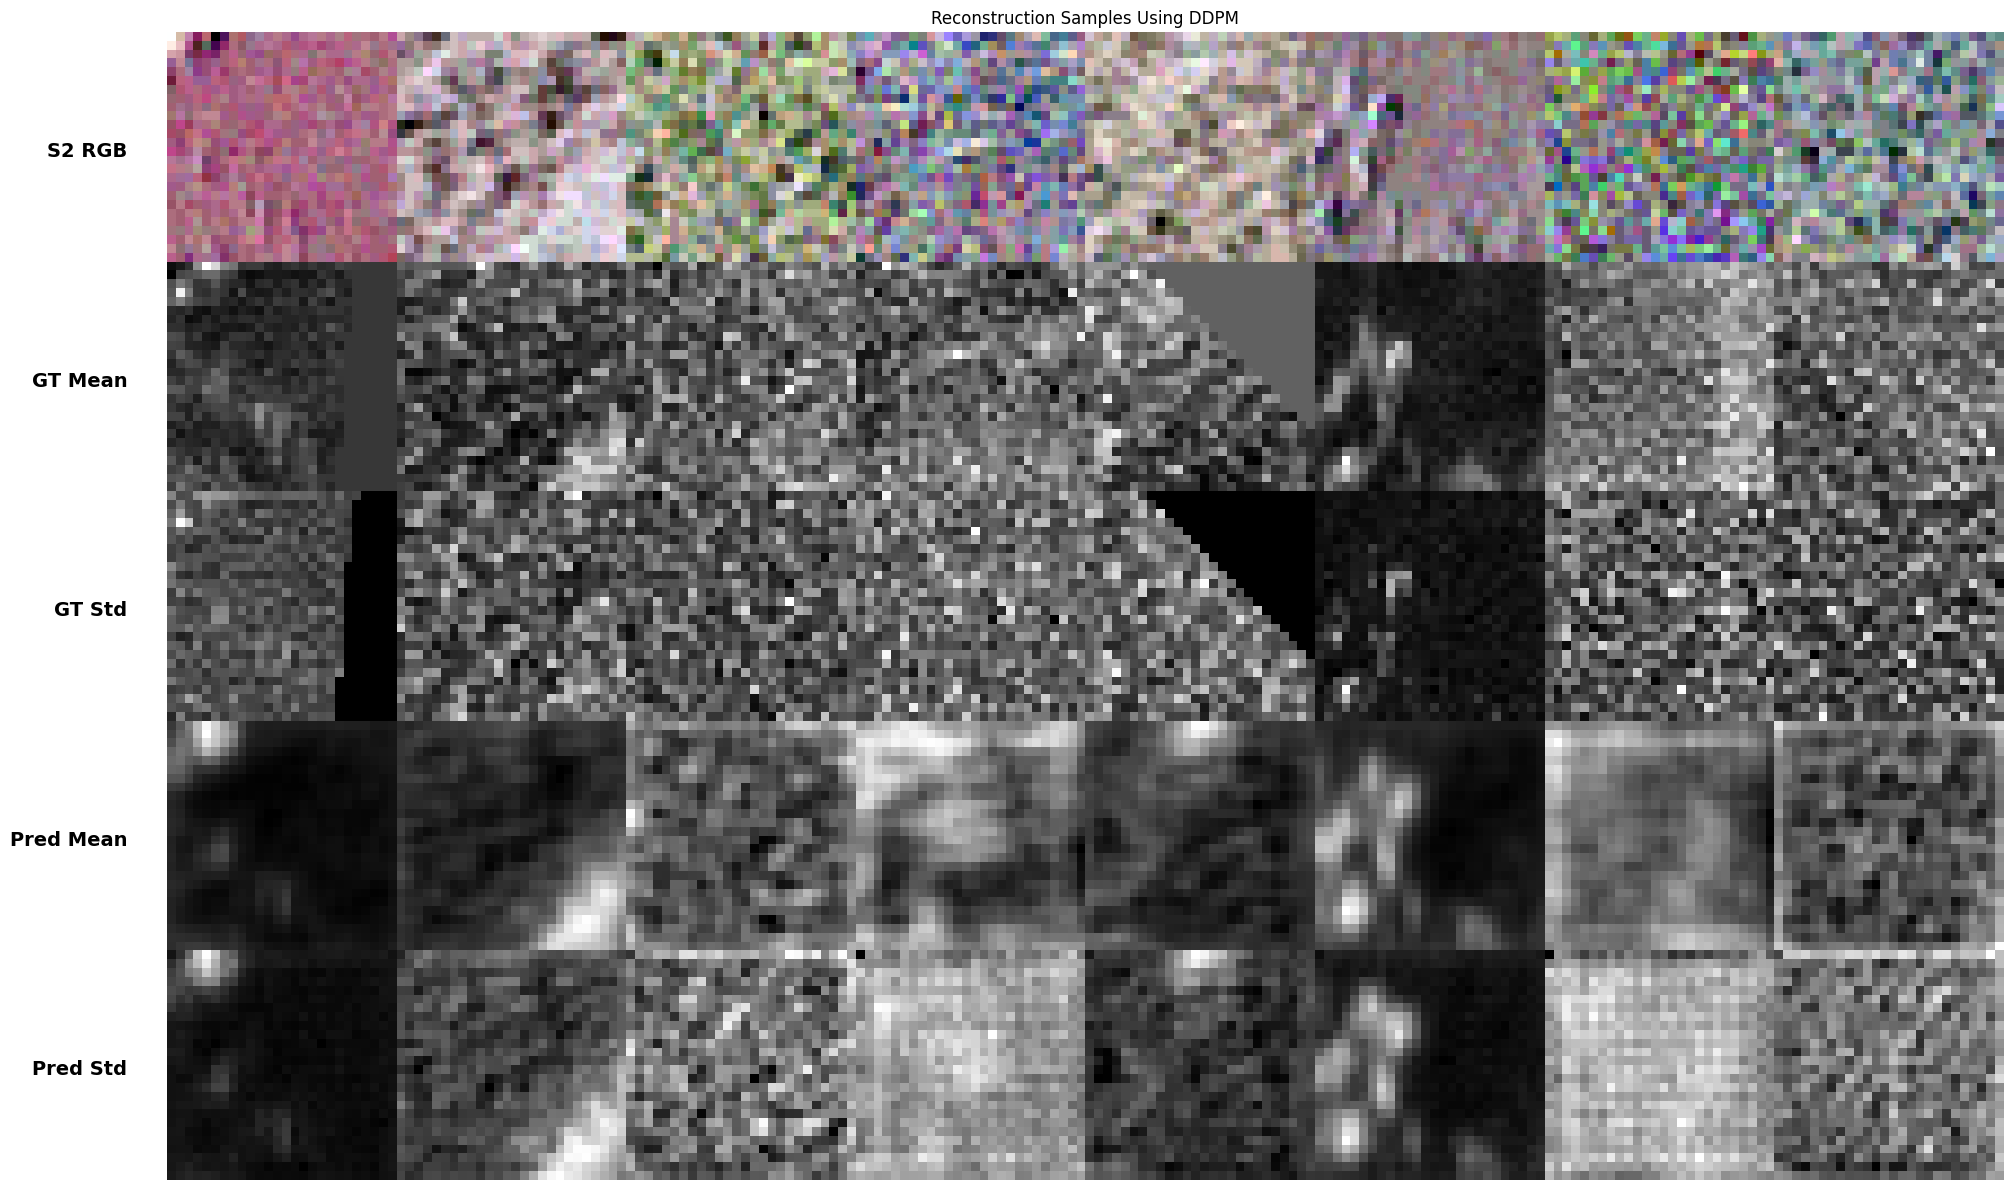


Sampling method: DDIM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0368      |     0.0168     
RMSE                 |     0.0493      |     0.0237     
Normalized RMSE (%)  |      6.96       |      6.51      
SSIM                 |     0.3367      |     0.3099     


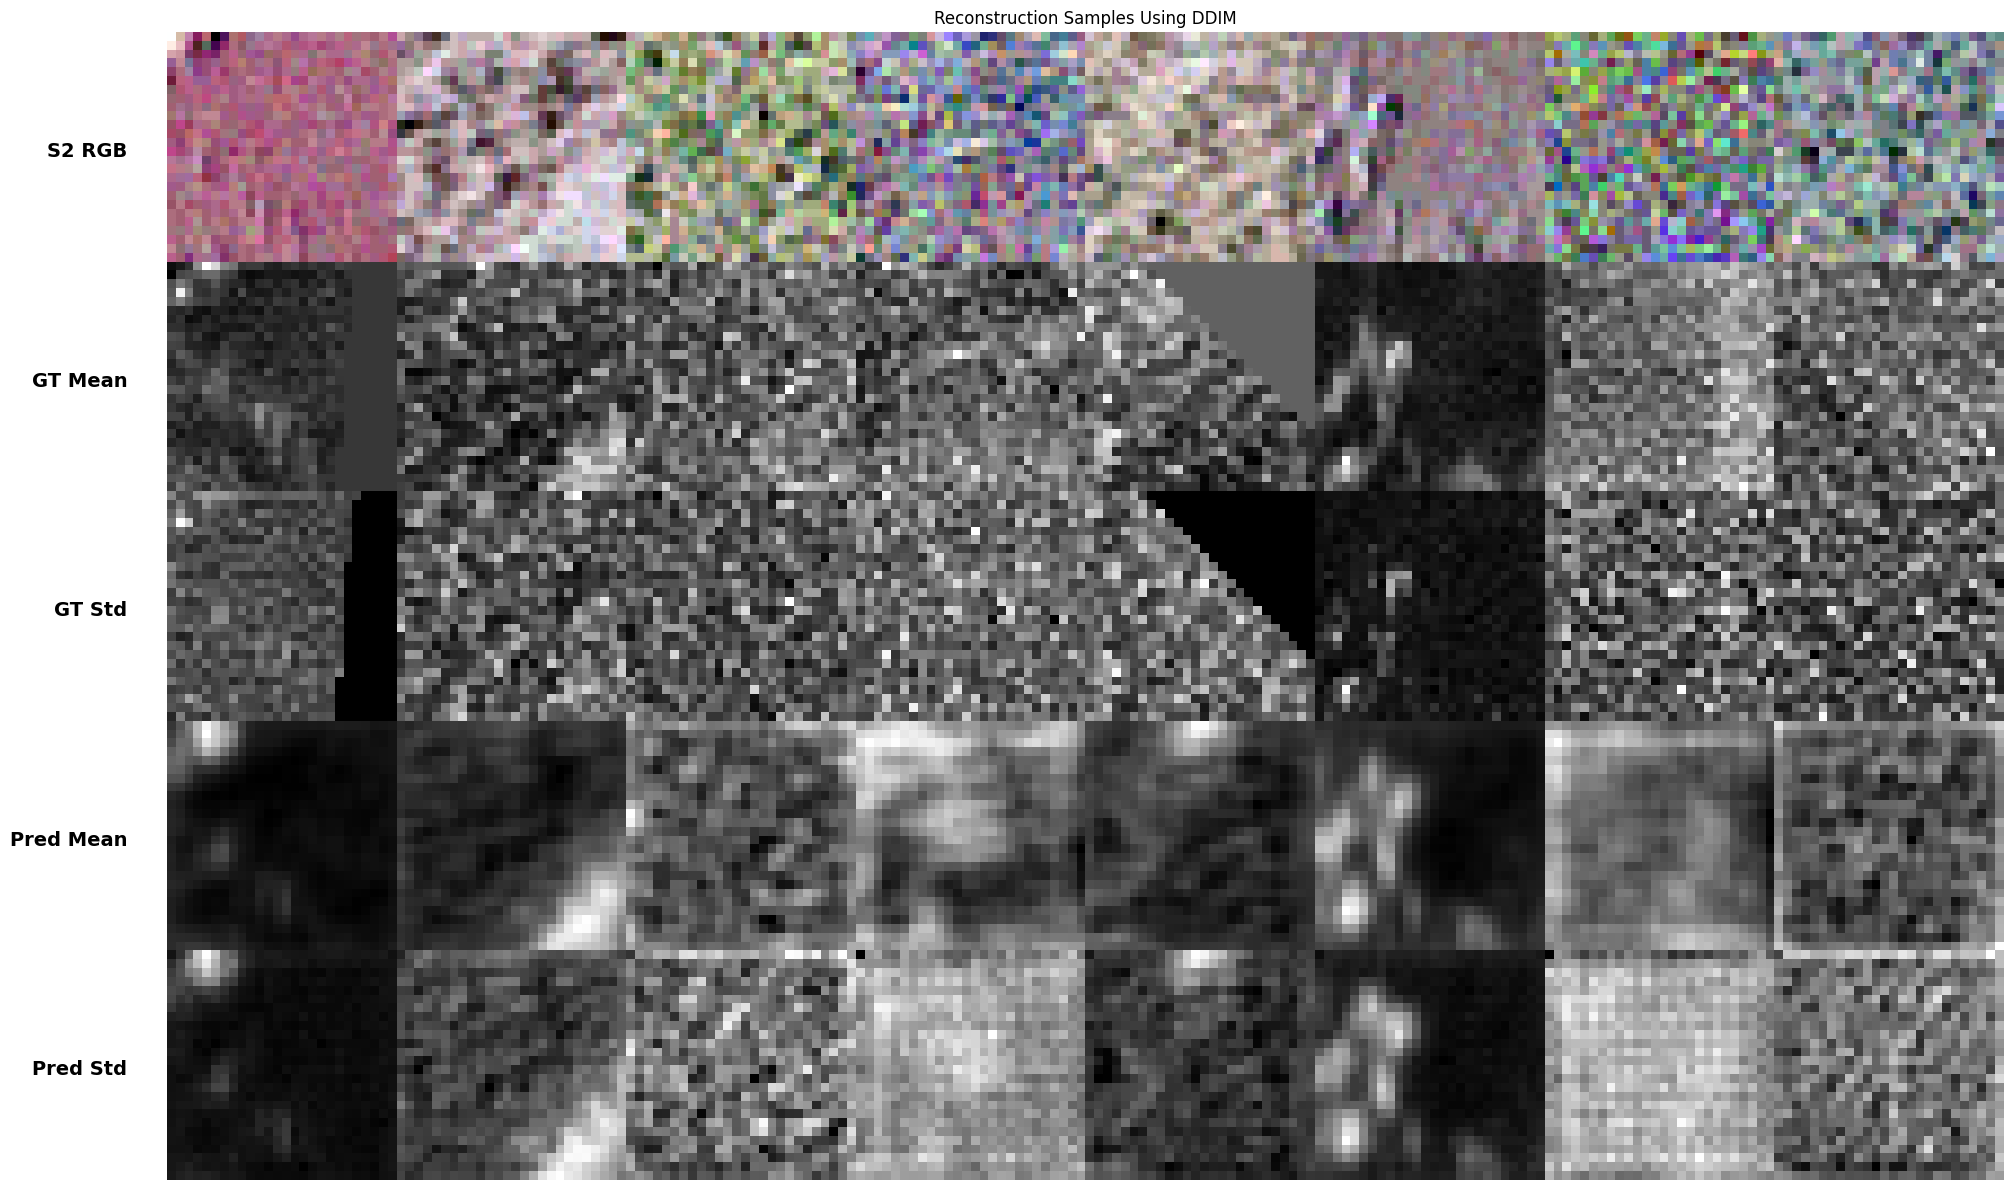


Sampling method: PLMS
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0369      |     0.0168     
RMSE                 |     0.0494      |     0.0238     
Normalized RMSE (%)  |      6.97       |      6.52      
SSIM                 |     0.3377      |     0.3097     


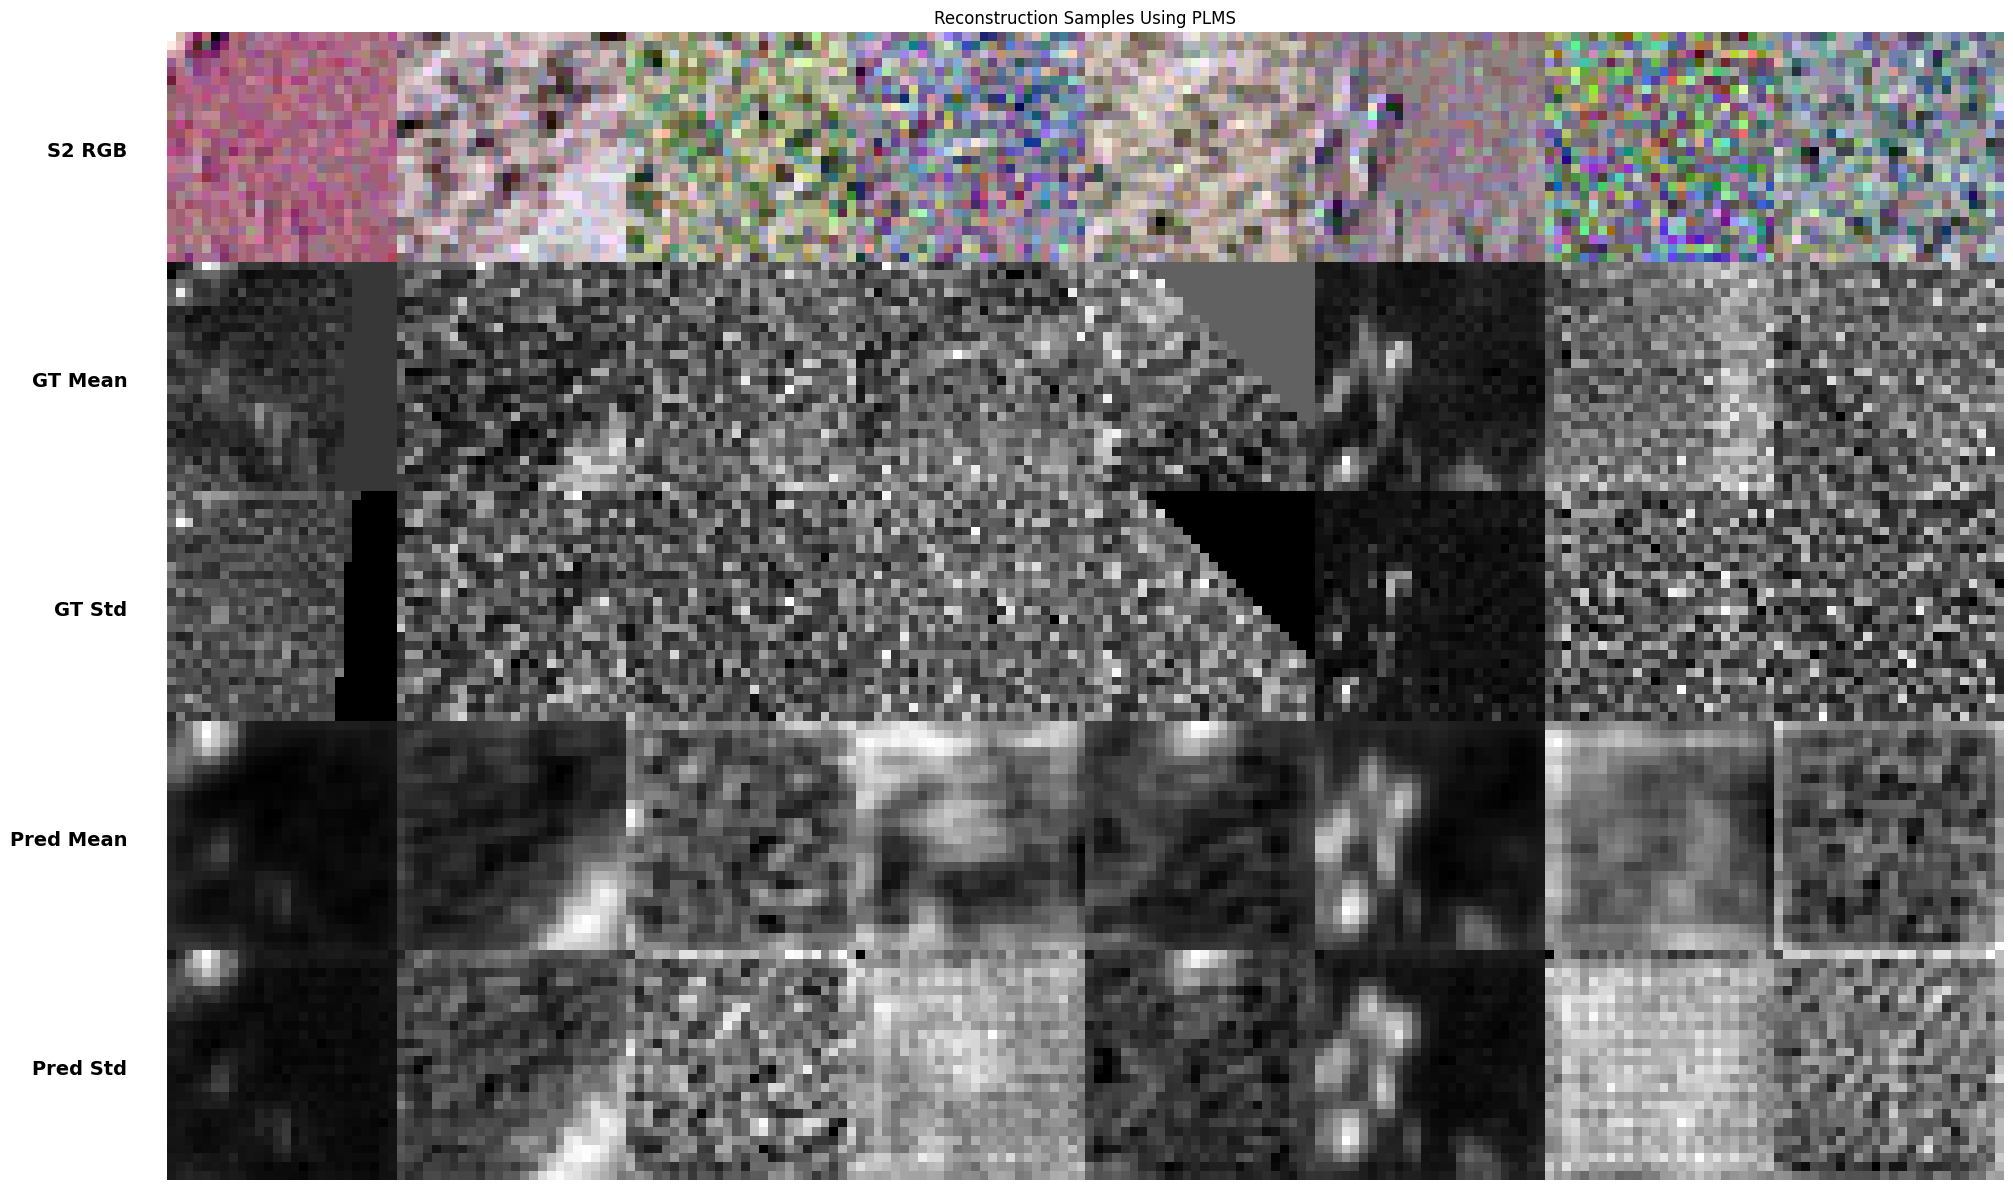

In [15]:
# Reconstruction Evaluation

# Set model to eval
model.eval()

# Extract sample batch from the test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
batch = next(iter(test_loader))
s2 = batch["s2"].to(config["device"])
lidar = batch["lidar"].to(config["device"])

# Define p sampling methods to test
p_samplers = {"DDPM": p_sample_loop_ddpm, "DDIM": p_sample_loop_ddim, "PLMS": p_sample_loop_plms}

# Perform evaluation for each p sampling method
for p_sampler in p_samplers: 
    print(f"\nSampling method: {p_sampler}")
    
    with torch.no_grad():
        generated = p_samplers[p_sampler](model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])
        
        # Get GT and pred channels
        gt_mean = lidar[:, 0:1].cpu()
        gt_std = lidar[:, 1:2].cpu()
        pred_mean = generated[:, 0:1].cpu()
        pred_std = generated[:, 1:2].cpu()

        # Normalize to [0, 1] for SSIM/LPIPS
        
        gt_mean_norm = normalize(gt_mean)
        gt_std_norm = normalize(gt_std)
        pred_mean_norm = normalize(pred_mean)
        pred_std_norm = normalize(pred_std)

        # RMSE, MAE
        mae_mean = F.l1_loss(pred_mean, gt_mean).item()
        rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
        mae_std = F.l1_loss(pred_std, gt_std).item()
        rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

        # Normalized RMSE
        nrmse_mean = compute_nrmse(gt_mean.numpy(), pred_mean.numpy())
        nrmse_std = compute_nrmse(gt_std.numpy(), pred_std.numpy())

        # SSIM
        ssim_mean = ssim(pred_mean_norm, gt_mean_norm, data_range=1.0).item()
        ssim_std = ssim(pred_std_norm, gt_std_norm, data_range=1.0).item()

        # Print results
        print(f"{'Metric':<20} | {'Mean Elevation':^15} | {'Std Elevation':^15}")
        print("-" * 55)
        print(f"{'MAE':<20} | {mae_mean:^15.4f} | {mae_std:^15.4f}")
        print(f"{'RMSE':<20} | {rmse_mean:^15.4f} | {rmse_std:^15.4f}")
        print(f"{'Normalized RMSE (%)':<20} | {nrmse_mean:^15.2f} | {nrmse_std:^15.2f}")
        print(f"{'SSIM':<20} | {ssim_mean:^15.4f} | {ssim_std:^15.4f}")

        # Reconstruction Visualization
        s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())
        gt_mean_vis = rescale_batch_channelwise(gt_mean[:8])
        gt_std_vis = rescale_batch_channelwise(gt_std[:8])
        pred_mean_vis = rescale_batch_channelwise(pred_mean[:8])
        pred_std_vis = rescale_batch_channelwise(pred_std[:8])

        vis_list = []
        for i in range(8):
            stacked = torch.cat([
                s2_vis[i],
                gt_mean_vis[i].repeat(3, 1, 1),
                gt_std_vis[i].repeat(3, 1, 1),
                pred_mean_vis[i].repeat(3, 1, 1),
                pred_std_vis[i].repeat(3, 1, 1)
            ], dim=1)
            vis_list.append(stacked)

        final_grid = torch.cat(vis_list, dim=2)
        img = final_grid.permute(1, 2, 0).numpy()

        # Add row titles
        row_labels = ["S2 RGB", "GT Mean", "GT Std", "Pred Mean", "Pred Std"]
        n_rows = len(row_labels)
        row_height = img.shape[0] // n_rows

        plt.figure(figsize=(40, 12))
        plt.imshow(img)
        plt.title(f"Reconstruction Samples Using {p_sampler}")
        plt.axis("off")

        # Add row labels on the left
        for idx, label in enumerate(row_labels):
            y = row_height * idx + row_height // 2
            plt.text(-5, y, label, va='center', ha='right', fontsize=14, fontweight='bold', color='black', backgroundcolor='white')

        plt.tight_layout()
        plt.show()


### Batch Sample #3


Sampling method: DDPM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0448      |     0.0149     
RMSE                 |     0.0583      |     0.0204     
Normalized RMSE (%)  |      10.09      |      7.19      
SSIM                 |     0.2541      |     0.2191     


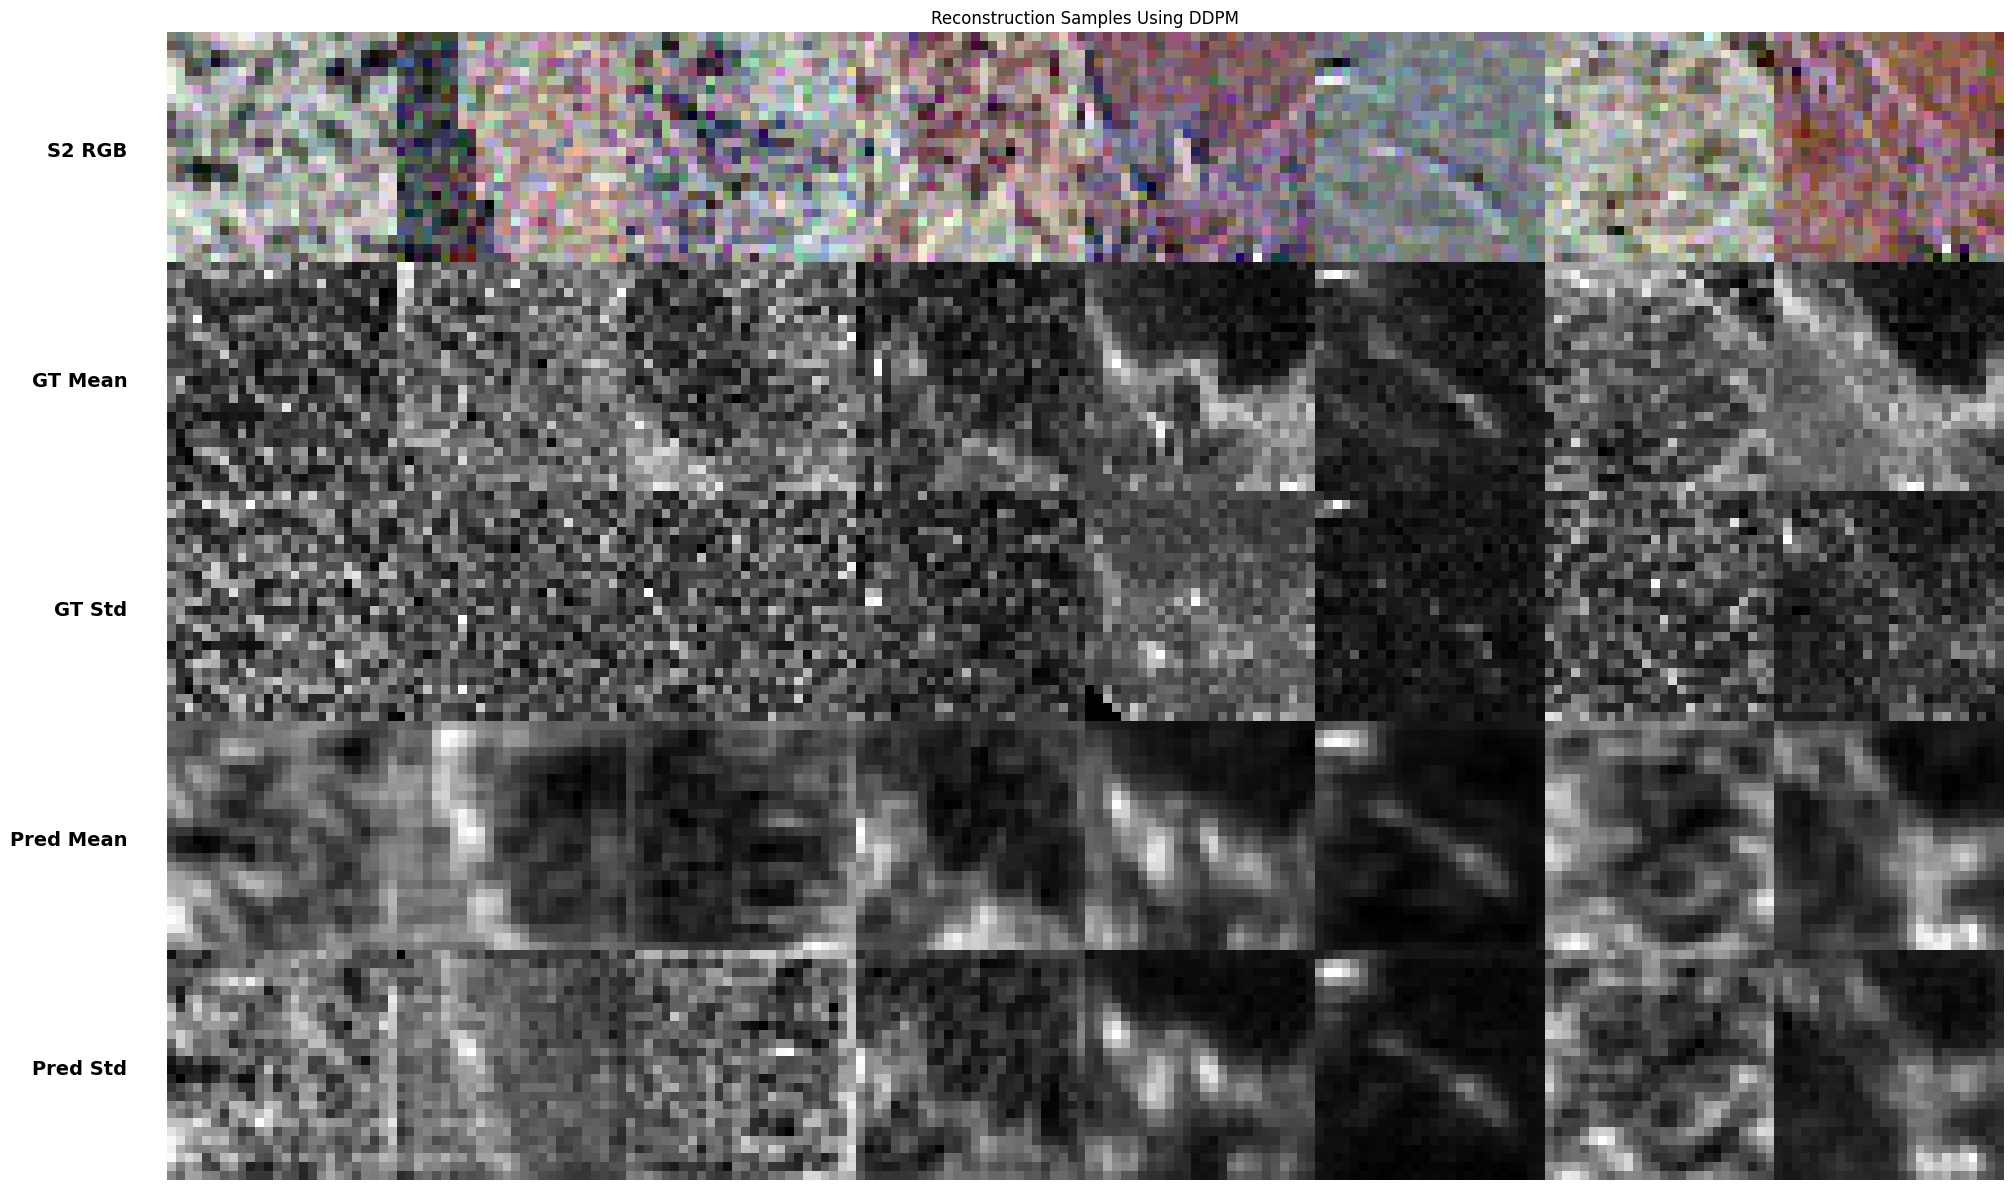


Sampling method: DDIM
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0447      |     0.0150     
RMSE                 |     0.0583      |     0.0204     
Normalized RMSE (%)  |      10.10      |      7.20      
SSIM                 |     0.2534      |     0.2186     


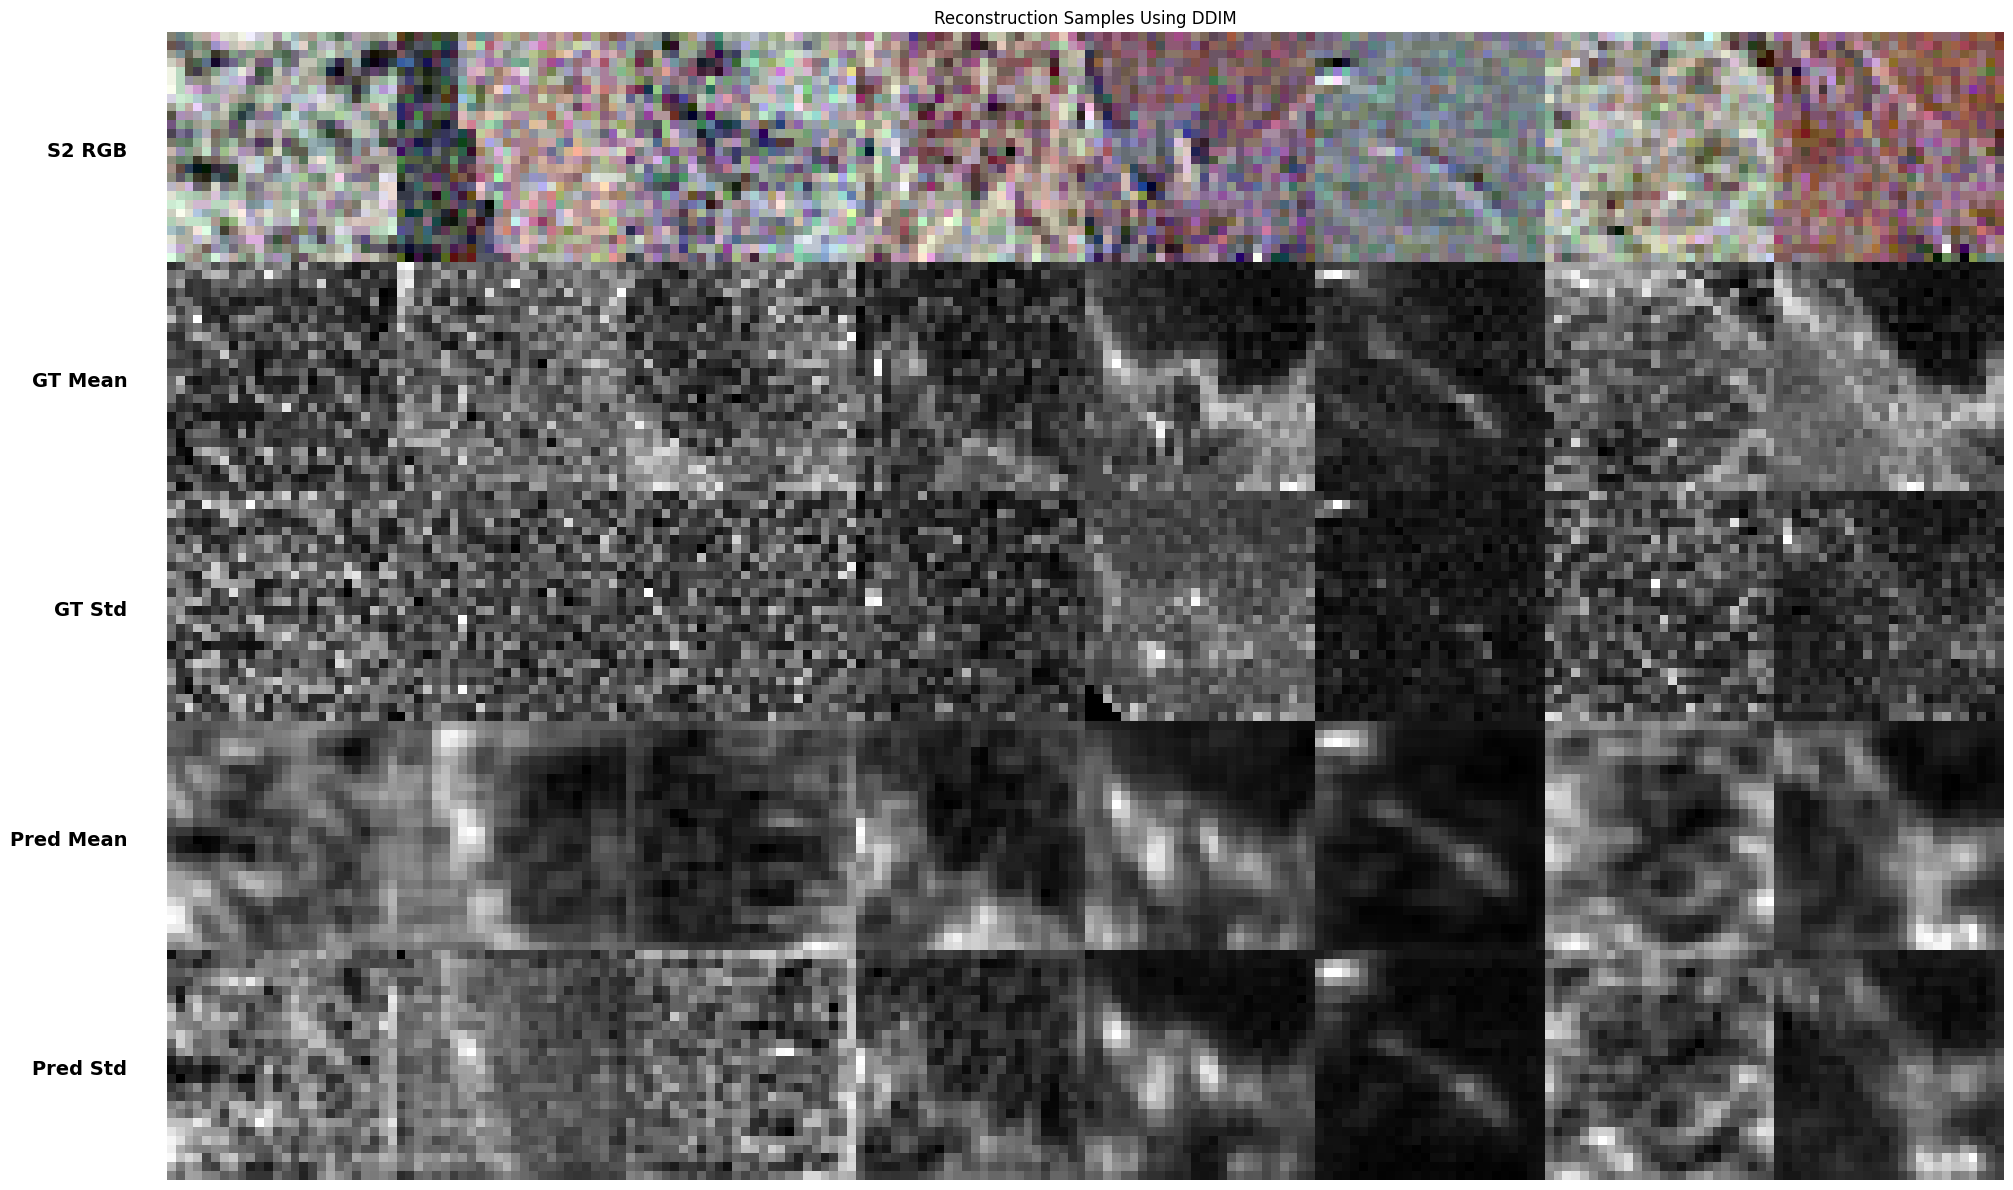


Sampling method: PLMS
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0449      |     0.0149     
RMSE                 |     0.0585      |     0.0204     
Normalized RMSE (%)  |      10.14      |      7.19      
SSIM                 |     0.2544      |     0.2204     


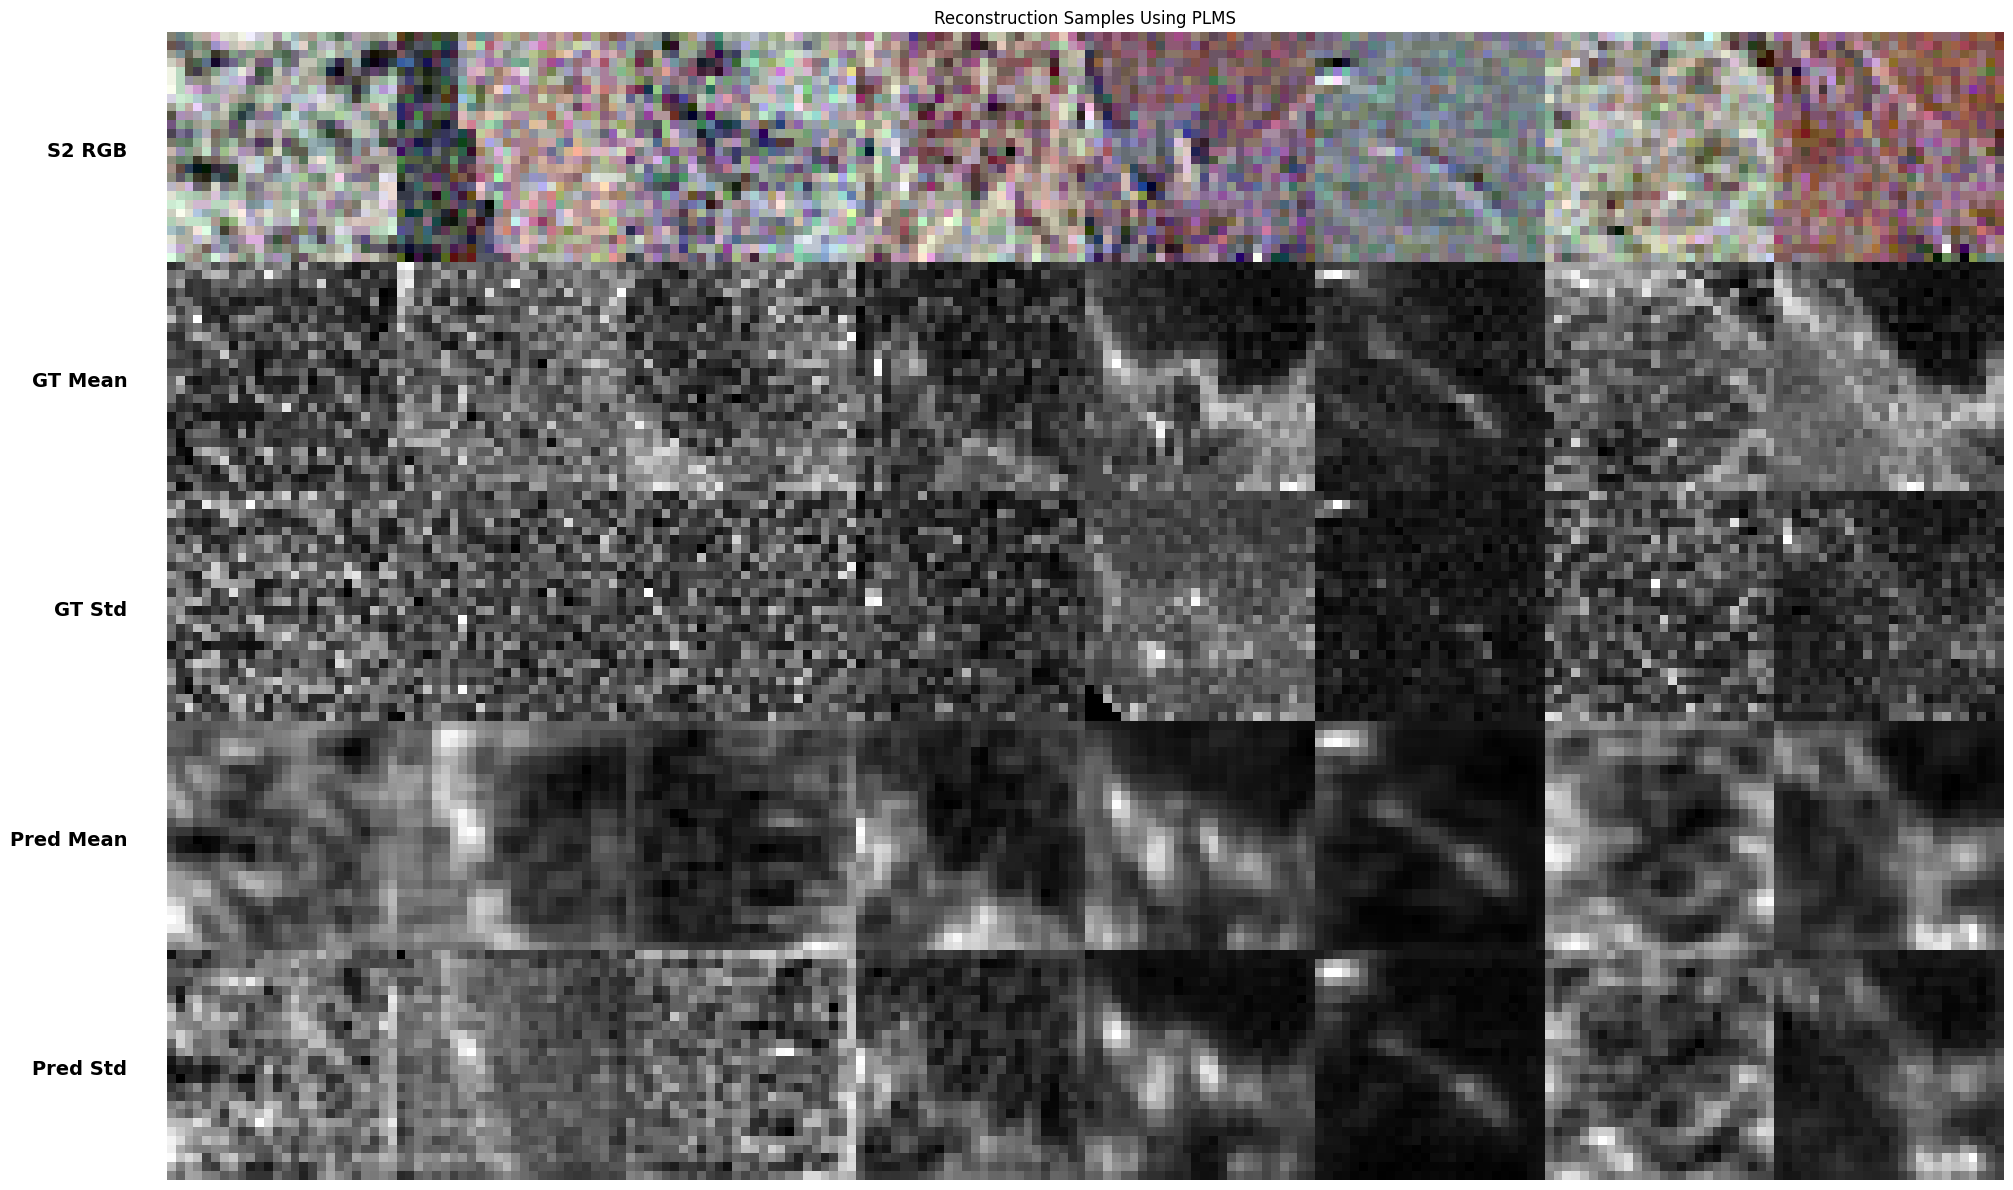

In [16]:
# Reconstruction Evaluation

# Set model to eval
model.eval()

# Extract sample batch from the test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
batch = next(iter(test_loader))
s2 = batch["s2"].to(config["device"])
lidar = batch["lidar"].to(config["device"])

# Define p sampling methods to test
p_samplers = {"DDPM": p_sample_loop_ddpm, "DDIM": p_sample_loop_ddim, "PLMS": p_sample_loop_plms}

# Perform evaluation for each p sampling method
for p_sampler in p_samplers: 
    print(f"\nSampling method: {p_sampler}")
    
    with torch.no_grad():
        generated = p_samplers[p_sampler](model, scheduler, shape=lidar.shape, cond=s2, device=config["device"])
        
        # Get GT and pred channels
        gt_mean = lidar[:, 0:1].cpu()
        gt_std = lidar[:, 1:2].cpu()
        pred_mean = generated[:, 0:1].cpu()
        pred_std = generated[:, 1:2].cpu()

        # Normalize to [0, 1] for SSIM/LPIPS
        
        gt_mean_norm = normalize(gt_mean)
        gt_std_norm = normalize(gt_std)
        pred_mean_norm = normalize(pred_mean)
        pred_std_norm = normalize(pred_std)

        # RMSE, MAE
        mae_mean = F.l1_loss(pred_mean, gt_mean).item()
        rmse_mean = F.mse_loss(pred_mean, gt_mean).sqrt().item()
        mae_std = F.l1_loss(pred_std, gt_std).item()
        rmse_std = F.mse_loss(pred_std, gt_std).sqrt().item()

        # Normalized RMSE
        nrmse_mean = compute_nrmse(gt_mean.numpy(), pred_mean.numpy())
        nrmse_std = compute_nrmse(gt_std.numpy(), pred_std.numpy())

        # SSIM
        ssim_mean = ssim(pred_mean_norm, gt_mean_norm, data_range=1.0).item()
        ssim_std = ssim(pred_std_norm, gt_std_norm, data_range=1.0).item()

        # Print results
        print(f"{'Metric':<20} | {'Mean Elevation':^15} | {'Std Elevation':^15}")
        print("-" * 55)
        print(f"{'MAE':<20} | {mae_mean:^15.4f} | {mae_std:^15.4f}")
        print(f"{'RMSE':<20} | {rmse_mean:^15.4f} | {rmse_std:^15.4f}")
        print(f"{'Normalized RMSE (%)':<20} | {nrmse_mean:^15.2f} | {nrmse_std:^15.2f}")
        print(f"{'SSIM':<20} | {ssim_mean:^15.4f} | {ssim_std:^15.4f}")

        # Reconstruction Visualization
        s2_vis = rescale_batch_channelwise(s2[:8, :3].cpu())
        gt_mean_vis = rescale_batch_channelwise(gt_mean[:8])
        gt_std_vis = rescale_batch_channelwise(gt_std[:8])
        pred_mean_vis = rescale_batch_channelwise(pred_mean[:8])
        pred_std_vis = rescale_batch_channelwise(pred_std[:8])

        vis_list = []
        for i in range(8):
            stacked = torch.cat([
                s2_vis[i],
                gt_mean_vis[i].repeat(3, 1, 1),
                gt_std_vis[i].repeat(3, 1, 1),
                pred_mean_vis[i].repeat(3, 1, 1),
                pred_std_vis[i].repeat(3, 1, 1)
            ], dim=1)
            vis_list.append(stacked)

        final_grid = torch.cat(vis_list, dim=2)
        img = final_grid.permute(1, 2, 0).numpy()

        # Add row titles
        row_labels = ["S2 RGB", "GT Mean", "GT Std", "Pred Mean", "Pred Std"]
        n_rows = len(row_labels)
        row_height = img.shape[0] // n_rows

        plt.figure(figsize=(40, 12))
        plt.imshow(img)
        plt.title(f"Reconstruction Samples Using {p_sampler}")
        plt.axis("off")

        # Add row labels on the left
        for idx, label in enumerate(row_labels):
            y = row_height * idx + row_height // 2
            plt.text(-5, y, label, va='center', ha='right', fontsize=14, fontweight='bold', color='black', backgroundcolor='white')

        plt.tight_layout()
        plt.show()
